In [26]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random

In [27]:
def read_img(name):
    with open(name) as f:
        lines = f.readlines()

    for l in list(lines):
        if l[0] == '#':
            lines.remove(l)

    assert lines[0].strip() == 'P2' or lines[0].strip() == 'P3'
    
    if lines[0].strip() == 'P2':
        data = []
        for line in lines[1:]:
            data.extend([int(c) for c in line.split()])
        matrix = np.array(data[3:])
        
        return ('P2',matrix.reshape(data[0],data[1]))
    
    if lines[0].strip() == 'P3':
        data = []
        for line in lines[1:]:
            data.extend([int(c) for c in line.split()])
        width, height, scale, *values = data
        rgb_values = [tuple(values[i:i+3]) for i in range(0,len(values),3)]
        rgb_matrix = [rgb_values[i:i+width] for i in range(0,len(rgb_values), width)]
        return ('P3',np.array(rgb_matrix))
       

In [39]:
def show_image(*img_matrix,cmap='gray'):
    for i in img_matrix:
        plt.imshow(i, cmap=cmap)
        plt.show()
        
def show_hist(img):
    if img[0] == 'P2':
        temp = img[1].reshape(-1)
        plt.hist(temp, bins=255)
        plt.show()
    if img[0] == 'P3':
        r = img[1][:,:,0].reshape(-1)
        g = img[1][:,:,1].reshape(-1)
        b = img[1][:,:,2].reshape(-1)
        plt.hist(r, bins=255)
        plt.title('Red Channel')
        plt.show()
        plt.hist(g, bins=255)
        plt.title('Green Channel')
        plt.show()
        plt.hist(b, bins=255)
        plt.title('Blue Channel')
        plt.show()
        

In [31]:
class KMeans():
    def __init__(self, img, img_type, cluster_num, weight, feature):
        assert cluster_num >= 2
        self.image = img.copy()
        self.shape = self.image.shape
        self.type = img_type
        self.cluster_num = cluster_num
        self.feature = feature
        self.weight = weight
        self.hist = Counter(list(self.image.reshape(-1)))
        self.fit()
        
        
    def fit(self):
        if self.type == 'P2':
            reimg = self.image.reshape(-1)
            maxp = max(reimg)
            minp = min(reimg)
            u = []
            t = [minp]
            deltau = (maxp-minp)/(self.cluster_num-1)
            for i in range(self.cluster_num):
                u.append(int(minp+i*deltau))
    
            for i in range(len(u)-1):
                tt = int((u[i+1]-u[i])//2) + u[i]
                t.append(tt)
            t.append(maxp+1)
            while True:
                lastU = u.copy()
                for i in range(len(u)):
                    u[i] = sum([self.hist[j]*j for j in range(t[i],t[i+1])]) // sum([self.hist[j] for j in range(t[i],t[i+1])])
                for i in range(len(u)-1):
                    t[i+1] = int((u[i+1]-u[i])//2) + u[i]
                    
                if self.listNoChange(lastU, u):
                    self.us = u.copy()
                    self.ts = t.copy()
                    break
                    
            self.IntensityThresholding()
                    
        if self.type == 'P3':
            weight = self.weight
            rgbxy = self.extendDimension()
            u = []
            uloc = []
            firstU = [random.randint(0, self.shape[0]), random.randint(0, self.shape[1])]
            u.append(rgbxy[firstU[0], firstU[1]])
            uloc.append(list(rgbxy[firstU[0], firstU[1]]*weight))
            for i in range(1, self.cluster_num):
                maxDist = 0
                maxPixelDist = u[0]
                for i in range(self.shape[0]):
                    for j in range(self.shape[1]):
                        if list(rgbxy[i,j]*weight) in uloc:
                            continue
                        totalDist = 0
                        for k in u:
                            totalDist += self.getPixelsDistance(k, rgbxy[i, j], weight)
                        if totalDist > maxDist:
                            maxDist = totalDist
                            maxPixelDist = rgbxy[i, j].copy()
                
                u.append(maxPixelDist)
                uloc.append(list(maxPixelDist*weight))
        
            clusters = {}
            for i in range(self.cluster_num):
                clusters[i] = []
                
            while True:
                for i in range(self.shape[0]):
                    for j in range(self.shape[1]):
                        minDistance = float('inf')
                        minLocation = 0
                        for iloc in range(0, self.cluster_num):
                            dist = self.getPixelsDistance(u[iloc], rgbxy[i, j], weight)
                            if dist < minDistance:
                                minDistance = dist
                                minLocation = iloc
                        clusters[minLocation].append(rgbxy[i, j])
                
                
                deltaU = 0
                
                for i in range(len(u)):
                    newu = np.array(clusters[i]).mean(axis=0)
                    deltaU += abs(newu-u[i])
                    u[i] = newu
                    
                if (deltaU < 1).all():
                    break
                    
                for i in clusters.keys():
                    clusters[i].clear()

            self.clustered_image = self.image.copy()
            for i in clusters.keys():
                u[i] = np.around(u[i])
                u[i] = u[i].astype(int)
                tempu = u[i].copy()
                for j in clusters[i]:
                    r, g, b, x, y = j
                    self.clustered_image[x, y] = tempu[:3]
                    
                    
    
    def getPixelRGB(self, location):
        return self.image[location[0],location[1]]
    
    def getPixelsDistance(self, pixel1, pixel2, weight):
        distance = ((pixel1-pixel2)**2 * weight).sum()
        
        return distance
    
    def extendDimension(self):
        rgbxy = self.image.copy()
        rgbxy = list(rgbxy)
        for i in range(self.shape[0]):
            rgbxy[i] = list(rgbxy[i])
            for j in range(self.shape[1]):
                rgbxy[i][j] = np.concatenate((rgbxy[i][j],np.array([i, j])))
            rgbxy[i] = np.array(rgbxy[i])
        return np.array(rgbxy)
                
    def listNoChange(self, list1, list2):
        for i in range(len(list1)):
            if abs(list1[i]-list2[i]) > 10e-5:
                return False
        return True
    
    def IntensityThresholding(self):
        self.clustered_image = self.image.copy()
        
        for i in range(len(self.ts)-1):
            self.clustered_image[np.logical_and(self.clustered_image<self.ts[i+1], self.clustered_image>=self.ts[i])] = self.us[i]
        
    def imshow(self, origin=True):
        if self.type == 'P2':
            if origin:
                plt.imshow(self.image, cmap='gray')
                plt.title('Origin')
                plt.show()
            plt.imshow(self.clustered_image, cmap='gray')
            plt.title('Clustered by %s'%self.cluster_num)
            plt.show()
            
        if self.type == 'P3':
            if origin:
                plt.imshow(self.image)
                plt.title('Origin')
                plt.show()
            plt.imshow(self.clustered_image)
            plt.title('%s Clustered by %s'%(self.feature, self.cluster_num))
            plt.show()

In [32]:
def K_means(image_path, cluster_num, feature="RGBXY"):
    img = read_img(image_path)
    features = {
        'RGBXY': np.array([1/5,1/5,1/5,1/5,1/5]),
        'RGB': np.array([1/3,1/3,1/3,0,0]),
        'XY': np.array([0,0,0,1/2,1/2])
    }
    if feature not in features.keys():
        print('Please input one of the following features: %s'%list(features.keys()))
        return None
    
    kmeans = KMeans(img[1], img[0], cluster_num, features[feature], feature)
    return kmeans

In [33]:
star6 = K_means('./star.ppm', 6, 'RGBXY')
star61 =  K_means('./star.ppm', 6, 'RGB')
star62 =  K_means('./star.ppm', 6, 'XY')

In [34]:
elephant6 = K_means('elephants.ppm', 6, 'RGBXY')
elephant61 = K_means('elephants.ppm', 6, 'RGB')
elephant62 = K_means('elephants.ppm', 6, 'XY')

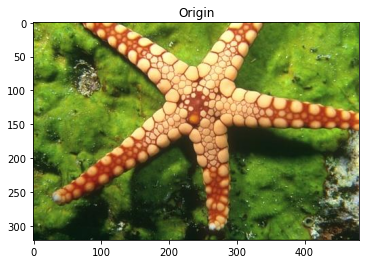

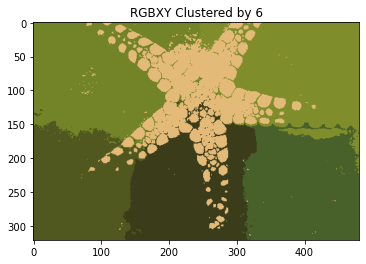

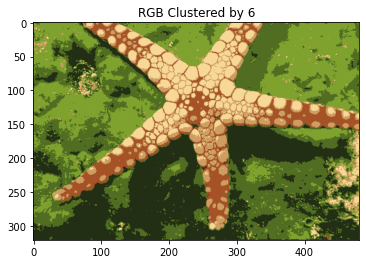

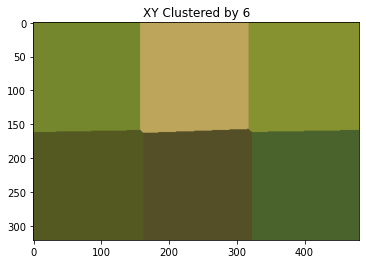

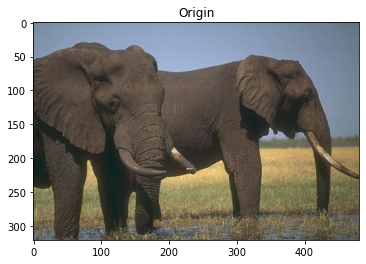

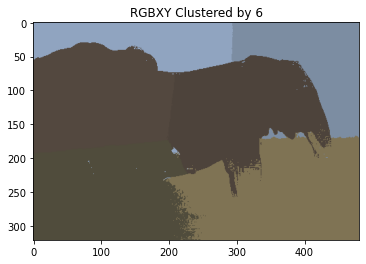

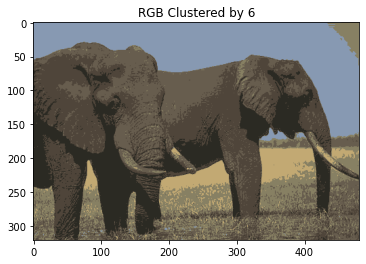

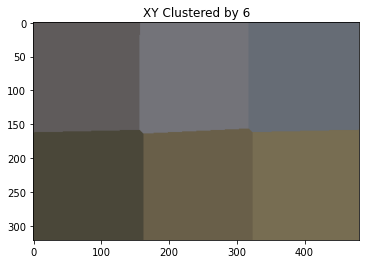

In [35]:
star6.imshow()
star61.imshow(False)
star62.imshow(False)
elephant6.imshow()
elephant61.imshow(False)
elephant62.imshow(False)

In [102]:
star = K_means('./star.ppm', 10, 'RGBXY')
star1 =  K_means('./star.ppm', 10, 'RGB')
star2 =  K_means('./star.ppm', 10, 'XY')
elephant = K_means('elephants.ppm', 10, 'RGBXY')
elephant1 = K_means('elephants.ppm', 10, 'RGB')
elephant2 = K_means('elephants.ppm', 10, 'XY')

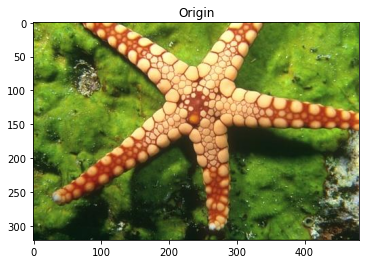

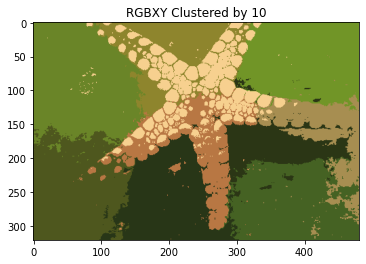

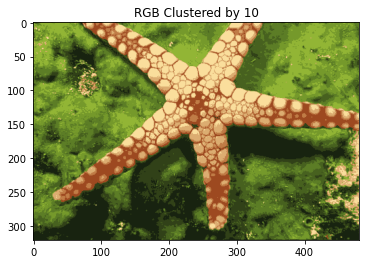

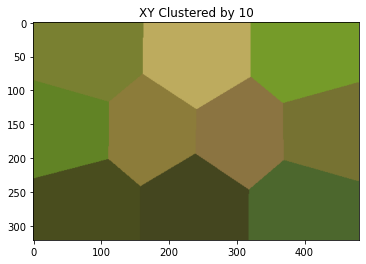

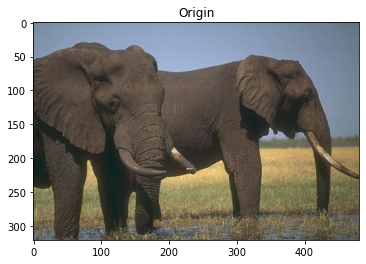

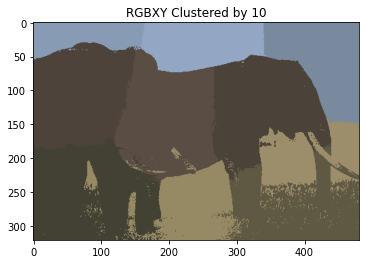

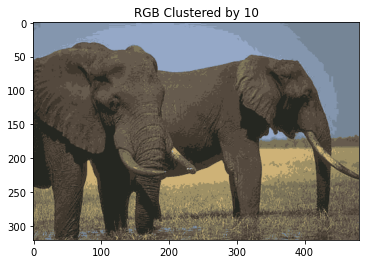

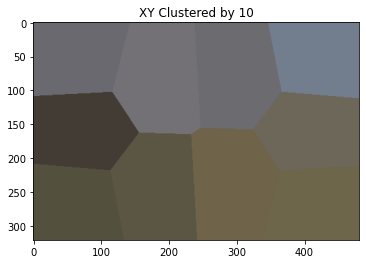

In [103]:
star.imshow()
star1.imshow(False)
star2.imshow(False)
elephant.imshow()
elephant1.imshow(False)
elephant2.imshow(False)

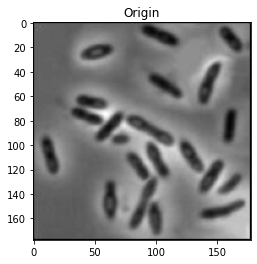

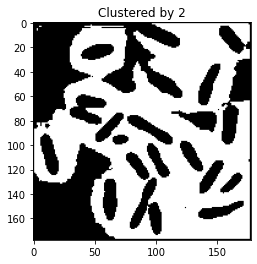

In [42]:
bacteria = K_means('bacteria.pgm', 2)
bacteria.imshow()


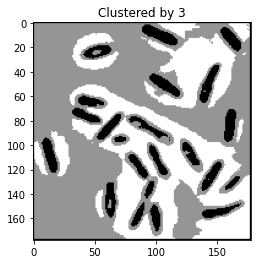

In [43]:
aa = K_means('bacteria.pgm', 3)
aa.imshow(False)

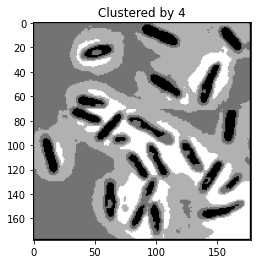

In [44]:
bacteria1 = K_means('bacteria.pgm', 4)
bacteria1.imshow(False)

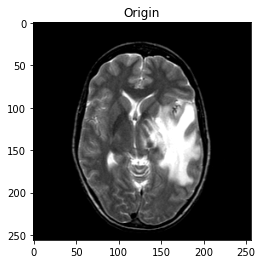

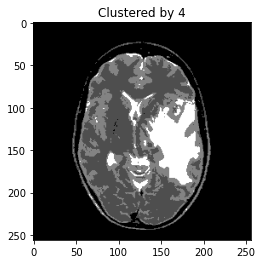

In [45]:
brain1 = K_means('brain.pgm', 4)
brain1.imshow()

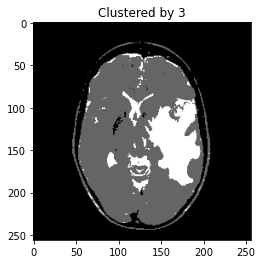

In [46]:
brain1 = K_means('brain.pgm', 3)
brain1.imshow(False)

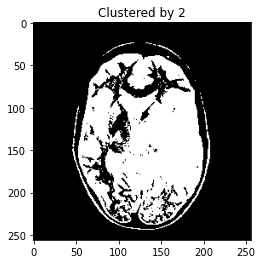

In [47]:
brain1 = K_means('brain.pgm', 2)
brain1.imshow(False)